In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 2 — Basics of Data and Preprocessing
## Lesson 9: Missingness Mechanisms (MCAR, MAR, MNAR) and Practical Implications


### Learning objectives
By the end of this lesson, you will be able to:

1. Use the formal missing-data notation $(Y, R)$ and interpret missingness mechanisms as conditional distributions $p(R\mid Y)$.
2. Distinguish **MCAR**, **MAR**, and **MNAR** in both mathematical terms and operational terms.
3. Explain why MCAR often justifies complete-case analysis (with caveats), why MAR motivates likelihood-based or imputation-based approaches, and why MNAR requires explicit modeling or sensitivity analysis.
4. Build practical diagnostics: missingness heatmaps, missingness indicators, and predictive checks that probe whether MCAR is plausible.
5. Quantify the effect of mechanisms on estimators and models using controlled experiments on multiple tabular datasets.


---
## 1) Missing data as a stochastic object: notation and factorization

Let $Y \in \mathbb{R}^{n\times p}$ be the (conceptual) **complete** data matrix with rows $i=1,\dots,n$ and columns (variables/features) $j=1,\dots,p$. We split it into observed and missing parts:
$$
Y = (Y_{\text{obs}},\, Y_{\text{mis}}).
$$

Define the **missingness indicator matrix** $R \in \{0,1\}^{n\times p}$ by
$$
R_{ij} =
\begin{cases}
1, & \text{if } Y_{ij} \text{ is observed},\\
0, & \text{if } Y_{ij} \text{ is missing}.
\end{cases}
$$

A missing-data mechanism is formalized as a conditional distribution
$$
p(R \mid Y, \psi),
$$
where $\psi$ are mechanism parameters. In the most general case, the joint model is
$$
p(Y, R \mid \theta, \psi) = p(Y \mid \theta)\, p(R \mid Y, \psi).
$$

This factorization is a modeling statement: we specify how data values are generated, and then how missingness occurs given those values.

### Patterns: monotone vs arbitrary
Missingness can be **monotone** (e.g., longitudinal dropout) or **arbitrary** (general tabular missingness). The lesson focuses on mechanisms (MCAR/MAR/MNAR), not specific patterns—because the same mechanism notions apply to both.


---
## 2) Definitions of MCAR, MAR, MNAR

### 2.1 MCAR — Missing Completely At Random
A mechanism is MCAR if missingness is independent of the data:
$$
p(R \mid Y, \psi) = p(R \mid \psi).
$$
Equivalently, $R \perp\!\!\!\perp Y$. Under MCAR, whether a value is missing carries no information about the value itself or any other variable.

Operational intuition: if values went missing due to random device glitches that do not correlate with subject characteristics, MCAR may be plausible.

### 2.2 MAR — Missing At Random (Rubin)
A mechanism is MAR if, conditioning on the observed part, missingness does not depend on the missing part:
$$
p(R \mid Y, \psi) = p(R \mid Y_{\text{obs}}, \psi).
$$
This allows missingness to depend on **observed** variables but not on the unseen values.

Operational intuition: income might be missing more often for younger respondents (observed age), but given age and other observed covariates, the probability of missing income does not further depend on the income value itself.

### 2.3 MNAR — Missing Not At Random
MNAR holds when missingness depends on unobserved values even after conditioning on what you see:
$$
p(R \mid Y, \psi) \text{ depends on } Y_{\text{mis}}.
$$
Operational intuition: very high incomes are systematically not reported, even after accounting for observed covariates. In that case, the missingness itself is informative about the missing value.

### Important warning
These definitions are about the **data-generating process**, not about the dataset alone. From a single dataset, you cannot *prove* MAR or MNAR; you can only build evidence, diagnostics, and domain-knowledge arguments.


---
## 3) Ignorability and why mechanisms matter for inference

Assume a parametric model $p(Y\mid\theta)$ for the complete data. If we had complete data, likelihood inference would use
$$
L(\theta; Y) = p(Y\mid\theta).
$$

With missingness, the observed-data likelihood is obtained by integrating out missing values:
$$
p(Y_{\text{obs}}, R \mid \theta, \psi) = \int p(Y\mid\theta)\, p(R\mid Y, \psi)\, dY_{\text{mis}}.
$$

### 3.1 When can we ignore the mechanism?
A classical result (Rubin) states that, for likelihood-based inference, the missingness mechanism can be *ignored* if:

1. The mechanism is **MAR**, and
2. The parameters are **distinct**, meaning $\theta$ and $\psi$ have independent parameter spaces (no shared constraints).

Then inference about $\theta$ can proceed using the observed-data likelihood based on $p(Y_{\text{obs}}\mid\theta)$ without modeling $p(R\mid Y,\psi)$.

Intuition: if missingness only depends on what we already observed, and does not constrain the data model parameters, then the missingness process does not inject additional information about $\theta$ beyond what is in $Y_{\text{obs}}$.

### 3.2 Why MNAR is hard
Under MNAR, you generally cannot write an observed-data likelihood that is free of the missingness model, because $p(R\mid Y)$ depends on $Y_{\text{mis}}$. Identifiability issues arise: different combinations of $p(Y\mid\theta)$ and $p(R\mid Y,\psi)$ can produce the same observed distribution.

This is why MNAR analysis often relies on:
- explicit missingness models (selection models, pattern-mixture models),
- sensitivity analysis (vary assumptions and inspect stability), or
- external data / follow-up sampling.


---
## 4) Practical implications: what can go wrong?

### 4.1 Complete-case analysis (listwise deletion)
Dropping rows with any missing values (complete-case analysis) changes the effective sample distribution. Under MCAR, this is often unbiased for means and regression slopes (but still increases variance). Under MAR/MNAR, it can be biased because the retained sample is not representative.

### 4.2 Imputation and model training
Imputation methods implicitly assume something about missingness:
- Many common methods are motivated under MAR (and sometimes MCAR).
- Under MNAR, naive imputation can systematically distort distributions.

### 4.3 Feature engineering with missingness indicators
In predictive modeling, missingness itself can be predictive (especially under MAR/MNAR). Adding indicators like $\mathbb{1}[Y_{ij} \text{ is missing}]$ can improve prediction, but it also encodes the missingness process. For causal interpretation, this can be problematic unless carefully justified.

### 4.4 Evaluation pitfalls
If missingness mechanisms differ between train and deployment (dataset shift), performance can change dramatically. You should treat the missingness pattern as part of the data distribution.


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

np.random.seed(42)


---
## 5) Loading multiple datasets from the repository

In this lesson we will use multiple datasets (classification and regression) to illustrate missingness mechanisms and their consequences.

We will *not* assume these datasets have natural missing values. Instead, we will **inject missingness** according to MCAR/MAR/MNAR in controlled ways, because the mechanism definitions refer to the data-generating process.


In [3]:
DATASETS = {
    "diabetes": Path("../../../Datasets/Classification/diabetes.csv"),
    "wine_quality": Path("../../../Datasets/Classification/Wine_Quality.csv"),
    "house_prices": Path("../../../Datasets/Regression/house-prices.csv"),
    "listings": Path("../../../Datasets/Regression/listings.csv"),
}

def load_csv(path: Path, **kwargs) -> pd.DataFrame:
    return pd.read_csv(path, **kwargs)

df_diabetes = load_csv(DATASETS["diabetes"])
df_wine = load_csv(DATASETS["wine_quality"])
df_house = load_csv(DATASETS["house_prices"])
df_listings = load_csv(DATASETS["listings"])

print("diabetes:", df_diabetes.shape)
print("wine_quality:", df_wine.shape)
print("house_prices:", df_house.shape)
print("listings:", df_listings.shape)

display(df_diabetes.head())
display(df_wine.head())
display(df_house.head())
display(df_listings.head())


diabetes: (768, 9)
wine_quality: (4898, 12)
house_prices: (128, 8)
listings: (94559, 18)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,57.0,1,51,2025-02-09,0.29,3,344,10,NaN
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,NaN,4,96,2024-04-28,0.52,1,11,2,NaN
2,17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,510.0,3,56,2024-02-19,0.33,5,293,0,NaN
3,24328,Battersea live/work artist house,41759,Joe,NaN,Wandsworth,51.47072,-0.16266,Entire home/apt,213.0,90,94,2022-07-19,0.54,1,194,0,NaN
4,31036,Bright compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,NaN,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100.0,2,126,2025-02-20,0.70,8,353,3,NaN


---
## 6) Diagnostics: visualizing and quantifying missingness

A first step is to look at **where** values are missing. In a notebook, a simple approach is a heatmap of $R$ (the missingness indicator).

Given a dataframe $X$, define
$$
R(X) = \mathbb{1}[X \text{ is not null}].
$$
If you see structured blocks or stripes, missingness is likely related to variables, time, groups, or data collection processes.

We will implement basic utilities that:
- compute missingness rates,
- build missingness indicators,
- plot missingness maps.


In [4]:
def missingness_summary(df: pd.DataFrame) -> pd.DataFrame:
    s = df.isna().mean().sort_values(ascending=False)
    return pd.DataFrame({
        "missing_rate": s,
        "missing_count": (df.isna().sum()).loc[s.index],
        "dtype": df.dtypes.loc[s.index].astype(str),
    })

def plot_missingness_map(df: pd.DataFrame, max_cols: int = 30, title: str = ""):
    cols = list(df.columns)[:max_cols]
    R = (~df[cols].isna()).astype(int).to_numpy()
    plt.figure(figsize=(min(14, 0.35*len(cols)+4), 5))
    plt.imshow(R, aspect="auto")
    plt.yticks([])
    plt.xticks(range(len(cols)), cols, rotation=90)
    plt.title(title or "Missingness map (1=observed, 0=missing)")
    plt.tight_layout()
    plt.show()

# Quick check on raw datasets (they may have few or no missing values)
display(missingness_summary(df_diabetes).head(10))
display(missingness_summary(df_wine).head(10))
display(missingness_summary(df_house).head(10))
display(missingness_summary(df_listings).head(10))


,missing_rate,missing_count,dtype
Pregnancies,0.0,0,int64
Glucose,0.0,0,int64
BloodPressure,0.0,0,int64
SkinThickness,0.0,0,int64
Insulin,0.0,0,int64
BMI,0.0,0,float64
DiabetesPedigreeFunction,0.0,0,float64
Age,0.0,0,int64
classification,0.0,0,object


,missing_rate,missing_count,dtype
fixed acidity,0.0,0,float64
volatile acidity,0.0,0,float64
citric acid,0.0,0,float64
residual sugar,0.0,0,float64
chlorides,0.0,0,float64
free sulfur dioxide,0.0,0,float64
total sulfur dioxide,0.0,0,float64
density,0.0,0,float64
pH,0.0,0,float64
sulphates,0.0,0,float64


,missing_rate,missing_count,dtype
Home,0.0,0,int64
Price,0.0,0,int64
SqFt,0.0,0,int64
Bedrooms,0.0,0,int64
Bathrooms,0.0,0,int64
Offers,0.0,0,int64
Brick,0.0,0,object
Neighborhood,0.0,0,object


,missing_rate,missing_count,dtype
license,1.000000,94559,float64
neighbourhood_group,1.000000,94559,float64
price,0.361869,34218,float64
reviews_per_month,0.256369,24242,float64
last_review,0.256369,24242,object
host_name,0.000560,53,object
name,0.000000,0,object
id,0.000000,0,int64
neighbourhood,0.000000,0,object
host_id,0.000000,0,int64


---
## 7) Injecting missingness by mechanism

To study mechanisms, we will create controlled missingness in a numeric column $X$ using three generators:

1. **MCAR:** choose entries uniformly at random.
2. **MAR:** missingness probability depends on an observed covariate $Z$.
3. **MNAR:** missingness probability depends on the value of $X$ itself.

We will implement these in a way that makes the dependency explicit.

### Logistic missingness model (convenient parameterization)
For MAR or MNAR, a common choice is a logistic model for the missingness indicator $M = \mathbb{1}[X \text{ is missing}]$:
$$
\mathbb{P}(M=1 \mid \cdot) = \sigma(\alpha + \beta\, g(\cdot)),
$$
where $\sigma(t) = \frac{1}{1+e^{-t}}$. This produces probabilities in $(0,1)$.

We will tune $(\alpha, \beta)$ so the overall missing rate is around a target value.


In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inject_mcar(df: pd.DataFrame, col: str, missing_rate: float, rng=np.random.default_rng(0)) -> pd.DataFrame:
    out = df.copy()
    mask = rng.uniform(size=len(out)) < missing_rate
    out.loc[mask, col] = np.nan
    return out

def tune_alpha_for_target(p_raw: np.ndarray, target: float) -> float:
    # Find alpha so that mean(sigmoid(alpha + logit(p_raw))) ~ target.
    # Here we treat p_raw as a standardized score and solve for alpha by binary search.
    lo, hi = -20.0, 20.0
    for _ in range(80):
        mid = (lo + hi) / 2
        m = sigmoid(mid + p_raw).mean()
        if m < target:
            lo = mid
        else:
            hi = mid
    return (lo + hi) / 2

def inject_mar(df: pd.DataFrame, col: str, driver_col: str, missing_rate: float, beta: float = 1.0,
               rng=np.random.default_rng(1)) -> pd.DataFrame:
    out = df.copy()
    z = out[driver_col].astype(float).to_numpy()
    z = (z - np.nanmean(z)) / (np.nanstd(z) + 1e-12)
    score = beta * z
    alpha = tune_alpha_for_target(score, missing_rate)
    p = sigmoid(alpha + score)
    mask = rng.uniform(size=len(out)) < p
    out.loc[mask, col] = np.nan
    return out, p

def inject_mnar(df: pd.DataFrame, col: str, missing_rate: float, beta: float = 1.0,
                rng=np.random.default_rng(2)) -> pd.DataFrame:
    out = df.copy()
    x = out[col].astype(float).to_numpy()
    x = (x - np.nanmean(x)) / (np.nanstd(x) + 1e-12)
    score = beta * x
    alpha = tune_alpha_for_target(score, missing_rate)
    p = sigmoid(alpha + score)
    mask = rng.uniform(size=len(out)) < p
    out.loc[mask, col] = np.nan
    return out, p


---
## 8) A theoretical checkpoint: unbiasedness of the sample mean under MCAR

Consider a scalar variable $X$ with i.i.d. samples $X_1,\dots,X_n$ and missingness indicators $R_i \in \{0,1\}$ where $R_i=1$ means observed.

The **complete-case mean** is
$$
\bar X_{\text{cc}} = \frac{\sum_{i=1}^n R_i X_i}{\sum_{i=1}^n R_i}.
$$

### Proposition (informal)
If missingness is MCAR and $\mathbb{P}(R_i=1)>0$, then $\bar X_{\text{cc}}$ is unbiased for $\mathbb{E}[X]$ *conditional on the number of observed cases*.

### Sketch
Under MCAR, $R_i$ is independent of $X_i$. Condition on $S=\sum_i R_i$ and on which indices are observed. The observed set is a random subset independent of the $X_i$ values, so the average over that subset has expectation $\mathbb{E}[X]$.

A key caveat: even if unbiased, variance increases because $S<n$ in expectation.

We will verify this numerically in a controlled experiment.


In [6]:
def monte_carlo_mean_bias(x: np.ndarray, missing_rate: float, trials: int = 2000) -> pd.DataFrame:
    rng = np.random.default_rng(123)
    true_mean = float(np.mean(x))
    est = []
    for _ in range(trials):
        r = (rng.uniform(size=len(x)) >= missing_rate).astype(int)
        if r.sum() == 0:
            continue
        est.append((r * x).sum() / r.sum())
    est = np.array(est)
    return pd.DataFrame({
        "true_mean": [true_mean],
        "mean_estimate": [float(est.mean())],
        "bias": [float(est.mean() - true_mean)],
        "std_estimate": [float(est.std(ddof=1))],
        "trials_used": [len(est)],
    })

# Use a numeric column from diabetes to test
x = df_diabetes["BMI"].astype(float).to_numpy()
display(monte_carlo_mean_bias(x, missing_rate=0.3, trials=3000))


,true_mean,mean_estimate,bias,std_estimate,trials_used
0,31.992578,31.987234,-0.005344,0.189302,3000


---
## 9) Diabetes dataset: MCAR vs MAR vs MNAR and model impact

We will use the diabetes dataset (binary classification label) to demonstrate how the same overall missing rate can lead to very different consequences depending on mechanism.

### Plan
1. Choose a feature (e.g., BMI) to corrupt.
2. Create three copies: MCAR, MAR (driven by Glucose), MNAR (driven by BMI itself).
3. Compare:
   - distribution shifts in BMI among observed rows,
   - bias in the BMI mean,
   - downstream predictive performance under different handling strategies:
     - complete-case (drop rows with missing BMI),
     - mean imputation,
     - adding a missingness indicator.

Even though imputation is covered more deeply in Lesson 10, we will use simple methods here to isolate the effect of the *mechanism*.


Missing rates:
MCAR: 0.3151041666666667
MAR : 0.3489583333333333
MNAR: 0.3645833333333333


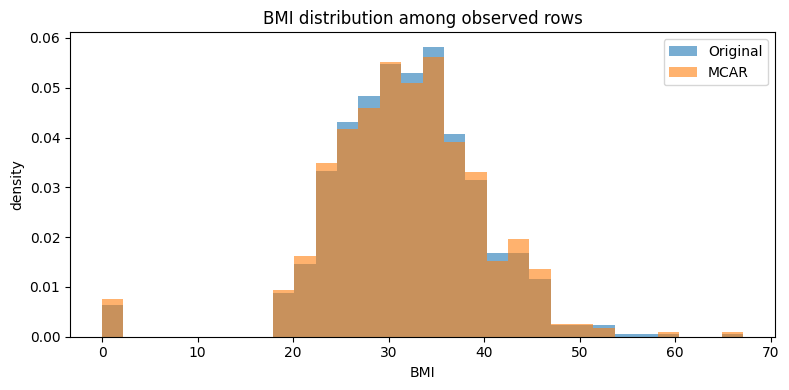

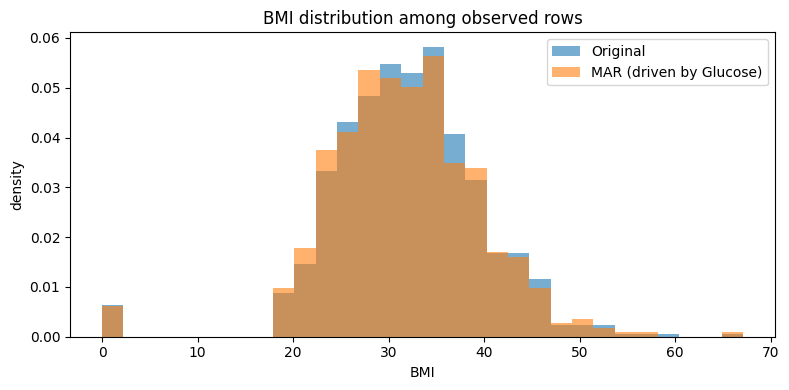

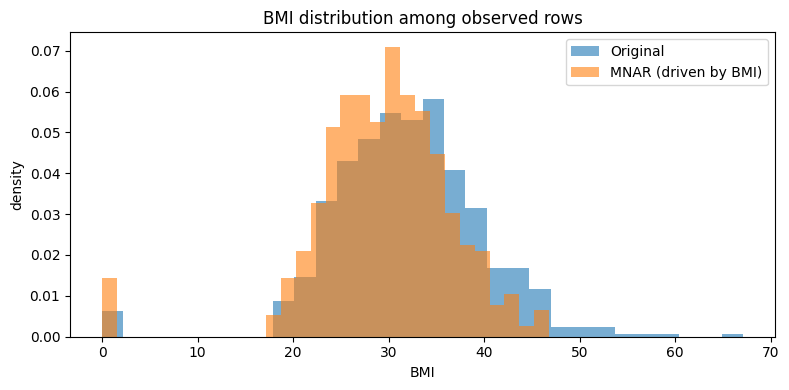

In [7]:
df0 = df_diabetes.copy()

target_missing = 0.35
df_mcar = inject_mcar(df0, col="BMI", missing_rate=target_missing)

df_mar, p_mar = inject_mar(df0, col="BMI", driver_col="Glucose", missing_rate=target_missing, beta=1.2)
df_mnar, p_mnar = inject_mnar(df0, col="BMI", missing_rate=target_missing, beta=1.2)

def compare_bmi_distributions(df_a, df_b, label_a="A", label_b="B"):
    a = df_a["BMI"].dropna().astype(float).to_numpy()
    b = df_b["BMI"].dropna().astype(float).to_numpy()
    plt.figure(figsize=(8,4))
    plt.hist(a, bins=30, alpha=0.6, label=label_a, density=True)
    plt.hist(b, bins=30, alpha=0.6, label=label_b, density=True)
    plt.title("BMI distribution among observed rows")
    plt.xlabel("BMI")
    plt.ylabel("density")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Missing rates:")
print("MCAR:", df_mcar["BMI"].isna().mean())
print("MAR :", df_mar["BMI"].isna().mean())
print("MNAR:", df_mnar["BMI"].isna().mean())

compare_bmi_distributions(df0, df_mcar, "Original", "MCAR")
compare_bmi_distributions(df0, df_mar, "Original", "MAR (driven by Glucose)")
compare_bmi_distributions(df0, df_mnar, "Original", "MNAR (driven by BMI)")


In [8]:
def bmi_mean_report(df, name):
    true_mean = float(df0["BMI"].astype(float).mean())
    cc_mean = float(df["BMI"].astype(float).dropna().mean())
    return {"dataset": name, "true_mean": true_mean, "complete_case_mean": cc_mean, "difference": cc_mean-true_mean}

report = pd.DataFrame([
    bmi_mean_report(df_mcar, "MCAR"),
    bmi_mean_report(df_mar, "MAR"),
    bmi_mean_report(df_mnar, "MNAR"),
])
display(report)


,dataset,true_mean,complete_case_mean,difference
0,MCAR,31.992578,31.906274,-0.086304
1,MAR,31.992578,31.761400,-0.231178
2,MNAR,31.992578,29.476025,-2.516554


### Interpretation
- Under **MCAR**, the observed BMI distribution and mean should remain close to the original (up to sampling noise).
- Under **MAR**, observed BMI can shift if BMI is correlated with the driver variable (Glucose). Even though missingness does not depend on BMI directly, it can induce bias in BMI summaries.
- Under **MNAR**, observed BMI is typically biased because missingness depends on BMI itself; the observed distribution is systematically distorted.

Next, we quantify model effects for predicting the diabetes classification label.


In [9]:
def prepare_xy(df: pd.DataFrame):
    y = df["classification"].astype(str)
    X = df.drop(columns=["classification"]).copy()
    return X, y

def evaluate_strategies(df: pd.DataFrame, title: str):
    X, y = prepare_xy(df)

    # Identify numeric/categorical columns
    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    cat_cols = [c for c in X.columns if c not in num_cols]

    # Strategy A: complete-case (drop rows with missing)
    mask = ~X.isna().any(axis=1)
    X_cc = X.loc[mask].copy()
    y_cc = y.loc[mask].copy()

    X_train, X_test, y_train, y_test = train_test_split(X_cc, y_cc, test_size=0.25, random_state=42, stratify=y_cc)

    pre_cc = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop",
    )
    clf_cc = Pipeline([
        ("pre", pre_cc),
        ("clf", LogisticRegression(max_iter=2000)),
    ])
    clf_cc.fit(X_train, y_train)
    proba = clf_cc.predict_proba(X_test)[:, 1]
    yhat = clf_cc.predict(X_test)

    # Strategy B: mean/mode imputation (no missingness indicator)
    pre_imp = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="mean"))]), num_cols),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                             ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ],
        remainder="drop",
    )
    clf_imp = Pipeline([("pre", pre_imp), ("clf", LogisticRegression(max_iter=2000))])
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    clf_imp.fit(X_train2, y_train2)
    proba2 = clf_imp.predict_proba(X_test2)[:, 1]
    yhat2 = clf_imp.predict(X_test2)

    # Strategy C: imputation + missingness indicator for numeric
    pre_ind = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="mean", add_indicator=True))]), num_cols),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                             ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ],
        remainder="drop",
    )
    clf_ind = Pipeline([("pre", pre_ind), ("clf", LogisticRegression(max_iter=2000))])
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    clf_ind.fit(X_train3, y_train3)
    proba3 = clf_ind.predict_proba(X_test3)[:, 1]
    yhat3 = clf_ind.predict(X_test3)

    def safe_auc(y_true, p, pos_label="Diabetic"):
        y01 = (y_true == pos_label).astype(int)
        return roc_auc_score(y01, p)

    results = pd.DataFrame([
        {"strategy": "complete_case_dropna", "n_train": len(X_train), "accuracy": accuracy_score(y_test, yhat),
         "roc_auc": safe_auc(y_test, proba)},
        {"strategy": "simple_impute", "n_train": len(X_train2), "accuracy": accuracy_score(y_test2, yhat2),
         "roc_auc": safe_auc(y_test2, proba2)},
        {"strategy": "impute_plus_missing_indicator", "n_train": len(X_train3), "accuracy": accuracy_score(y_test3, yhat3),
         "roc_auc": safe_auc(y_test3, proba3)},
    ])
    print(title)
    display(results)

evaluate_strategies(df_mcar, "Diabetes — BMI corrupted via MCAR")
evaluate_strategies(df_mar,  "Diabetes — BMI corrupted via MAR (depends on Glucose)")
evaluate_strategies(df_mnar, "Diabetes — BMI corrupted via MNAR (depends on BMI itself)")


Diabetes — BMI corrupted via MCAR


,strategy,n_train,accuracy,roc_auc
0,complete_case_dropna,394,0.772727,0.137260
1,simple_impute,576,0.786458,0.167045
2,impute_plus_missing_indicator,576,0.786458,0.168358


Diabetes — BMI corrupted via MAR (depends on Glucose)


,strategy,n_train,accuracy,roc_auc
0,complete_case_dropna,375,0.824000,0.176548
1,simple_impute,576,0.760417,0.191284
2,impute_plus_missing_indicator,576,0.760417,0.192955


Diabetes — BMI corrupted via MNAR (depends on BMI itself)


,strategy,n_train,accuracy,roc_auc
0,complete_case_dropna,366,0.803279,0.110465
1,simple_impute,576,0.791667,0.183045
2,impute_plus_missing_indicator,576,0.770833,0.173254


---
## 10) Probing MCAR plausibility with missingness indicator models

A widely used diagnostic idea is:

1. Choose a variable $X$ with missingness.
2. Define $M = \mathbb{1}[X \text{ is missing}]$.
3. Fit a predictive model $\widehat{M} = f(Z)$ from other observed variables $Z$.
4. If $M$ is strongly predictable from $Z$, MCAR is unlikely.

This does **not** prove MAR or MNAR; it only rejects MCAR-like behavior. Under MAR, missingness *is* allowed to depend on observed variables, so predictability is expected.

We will implement a simple logistic regression diagnostic for the diabetes examples.


In [10]:
from sklearn.metrics import roc_auc_score

def missingness_predictability(df: pd.DataFrame, missing_col: str, drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=[missing_col] + drop_cols).copy()
    M = df[missing_col].isna().astype(int)

    # Remove rows where predictors are missing (to keep the diagnostic focused)
    mask = ~X.isna().any(axis=1)
    X = X.loc[mask]
    M = M.loc[mask]

    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    cat_cols = [c for c in X.columns if c not in num_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="mean"))]), num_cols),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                             ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ],
        remainder="drop",
    )
    model = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=2000))])

    X_train, X_test, y_train, y_test = train_test_split(X, M, test_size=0.3, random_state=42, stratify=M)
    model.fit(X_train, y_train)
    p = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, p)
    return auc, int(M.sum()), len(M)

for name, dfx in [("MCAR", df_mcar), ("MAR", df_mar), ("MNAR", df_mnar)]:
    auc, miss, n = missingness_predictability(dfx, missing_col="BMI", drop_cols=["classification"])
    print(f"{name}: missing BMI count={miss}/{n}  |  AUC predicting missingness from other features = {auc:.3f}")


MCAR: missing BMI count=242/768  |  AUC predicting missingness from other features = 0.457
MAR: missing BMI count=268/768  |  AUC predicting missingness from other features = 0.769
MNAR: missing BMI count=280/768  |  AUC predicting missingness from other features = 0.563


### How to interpret the diagnostic
- AUC near 0.5 suggests missingness is not easily predictable from observed features (consistent with MCAR, but not conclusive).
- AUC significantly above 0.5 suggests missingness depends on observed features (inconsistent with MCAR; compatible with MAR or MNAR).

For MNAR, predictability can still happen if the missing variable is correlated with observed features, but MNAR cannot be ruled in or out using observed data alone.


---
## 11) Wine Quality dataset: MAR can bias summaries even without direct dependence on the missing variable

We now switch to a different dataset to emphasize that MAR can create biased complete-case summaries when the missing variable is correlated with the observed drivers.

We will:
- inject missingness into `residual sugar`,
- drive it by `alcohol` (observed) to create MAR,
- examine how complete-case distributions shift.


Missing rate: 0.30073499387505104


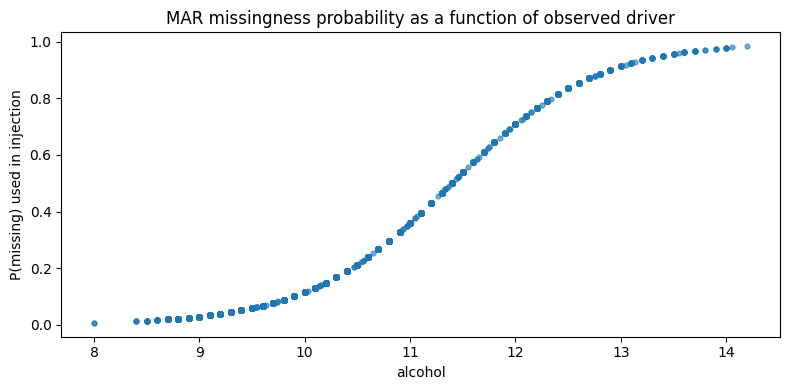

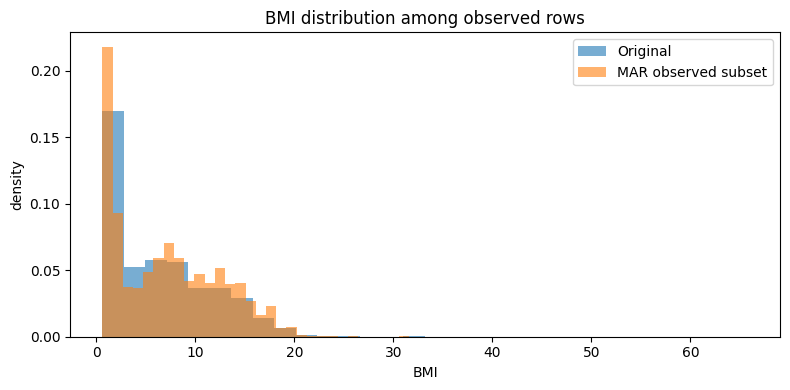

True mean: 6.391414863209474
Complete-case mean (after MAR): 7.184262773722628
Difference: 0.7928479105131538


In [11]:
dfw0 = df_wine.copy()

col_x = "residual sugar"
driver = "alcohol"

target_missing = 0.30
dfw_mar, p_wmar = inject_mar(dfw0, col=col_x, driver_col=driver, missing_rate=target_missing, beta=1.8)

print("Missing rate:", dfw_mar[col_x].isna().mean())

plt.figure(figsize=(8,4))
plt.scatter(dfw0[driver].to_numpy(), p_wmar, s=12, alpha=0.6)
plt.xlabel(driver)
plt.ylabel("P(missing) used in injection")
plt.title("MAR missingness probability as a function of observed driver")
plt.tight_layout()
plt.show()

# Distribution shift in residual sugar among observed cases
compare_bmi_distributions(
    dfw0.rename(columns={col_x:"BMI"}),
    dfw_mar.rename(columns={col_x:"BMI"}),
    "Original", "MAR observed subset"
)

true_mean = float(dfw0[col_x].mean())
cc_mean = float(dfw_mar[col_x].dropna().mean())
print("True mean:", true_mean)
print("Complete-case mean (after MAR):", cc_mean)
print("Difference:", cc_mean - true_mean)


---
## 12) MNAR illustration via a selection mechanism: why it is fundamentally not testable from observed data

To illustrate MNAR, we inject missingness that depends directly on the value itself. For example, suppose expensive rentals are more likely to have missing price (a plausible *data entry* pattern in some scraped datasets).

We will:
- take a numeric field from the listings dataset,
- inject MNAR missingness with higher probability when the value is high,
- quantify how the observed distribution is truncated.

Even if we can detect that missingness is correlated with observed covariates, we still cannot confirm dependence on the missing value after conditioning—because those values are precisely what we do not observe.


MNAR missing rate: 0.359


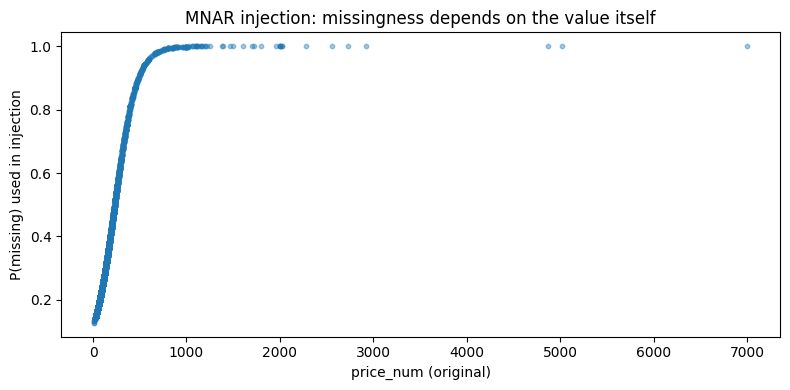

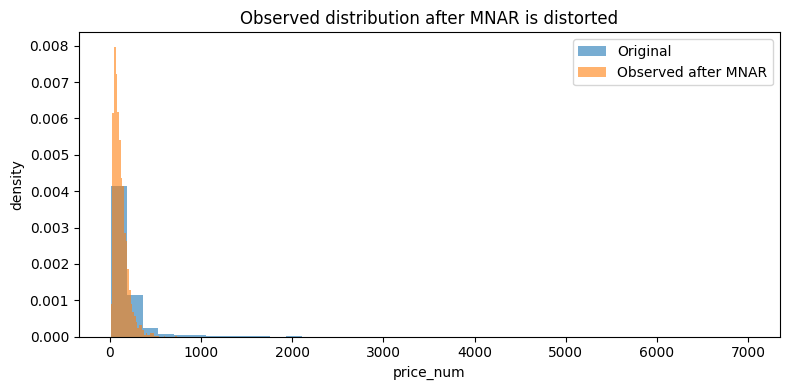

Original mean: 171.0238
Observed mean after MNAR: 115.80842433697347


In [12]:
# Choose a numeric column from listings that is commonly used
# (price may have missing values already; we will focus on MNAR injection to illustrate the concept)
dfl0 = df_listings.copy()

# Some datasets store price as string; try to coerce
if "price" in dfl0.columns:
    dfl0["price_num"] = pd.to_numeric(dfl0["price"], errors="coerce")
else:
    # If price column is absent, choose availability_365 as numeric demonstration
    dfl0["price_num"] = pd.to_numeric(dfl0.get("availability_365"), errors="coerce")

# Keep a subset with non-missing numeric values for controlled injection
base = dfl0.dropna(subset=["price_num"]).copy()
base = base.sample(n=min(len(base), 5000), random_state=42)  # keep it manageable

target_missing = 0.35
df_mnar_listings, p_mnar_list = inject_mnar(base, col="price_num", missing_rate=target_missing, beta=2.0)

print("MNAR missing rate:", df_mnar_listings["price_num"].isna().mean())

plt.figure(figsize=(8,4))
plt.scatter(base["price_num"].to_numpy(), p_mnar_list, s=10, alpha=0.4)
plt.xlabel("price_num (original)")
plt.ylabel("P(missing) used in injection")
plt.title("MNAR injection: missingness depends on the value itself")
plt.tight_layout()
plt.show()

# Compare observed distributions
a = base["price_num"].to_numpy()
b = df_mnar_listings["price_num"].dropna().to_numpy()

plt.figure(figsize=(8,4))
plt.hist(a, bins=40, alpha=0.6, density=True, label="Original")
plt.hist(b, bins=40, alpha=0.6, density=True, label="Observed after MNAR")
plt.xlabel("price_num")
plt.ylabel("density")
plt.title("Observed distribution after MNAR is distorted")
plt.legend()
plt.tight_layout()
plt.show()

print("Original mean:", float(np.mean(a)))
print("Observed mean after MNAR:", float(np.mean(b)))


---
## 13) Consequences for regression: a minimal analytic example

Consider the linear regression model
$$
Y = \beta_0 + \beta_1 X + \varepsilon, \quad \mathbb{E}[\varepsilon\mid X]=0.
$$

Suppose $Y$ is sometimes missing.

- Under **MCAR**, complete-case estimation of $(\beta_0,\beta_1)$ remains unbiased (though less efficient).
- Under **MAR**, if missingness depends on $X$ (which is observed), complete-case estimation can be biased because the conditional distribution of $X$ among observed $Y$ is shifted.
- Under **MNAR**, if missingness depends on $Y$ itself (e.g., large outcomes are more likely missing), complete-case estimation is typically biased even if $X$ is fully observed.

We will demonstrate this with a synthetic regression where we control the missingness mechanism of $Y$.


In [13]:
rng = np.random.default_rng(7)

n = 2000
X = rng.normal(size=n)
eps = rng.normal(scale=1.0, size=n)
Y = 1.0 + 2.0 * X + eps

df_syn = pd.DataFrame({"X": X, "Y": Y})

# Inject missingness into Y by mechanism
dfY_mcar = inject_mcar(df_syn, "Y", missing_rate=0.3, rng=rng)

dfY_mar, _ = inject_mar(df_syn, col="Y", driver_col="X", missing_rate=0.3, beta=1.5, rng=rng)   # depends on X (observed)

dfY_mnar, _ = inject_mnar(df_syn, col="Y", missing_rate=0.3, beta=1.5, rng=rng)                  # depends on Y itself

def fit_slope_complete_case(df):
    d = df.dropna(subset=["Y"]).copy()
    reg = LinearRegression().fit(d[["X"]], d["Y"])
    return float(reg.intercept_), float(reg.coef_[0]), len(d)

true_beta0, true_beta1 = 1.0, 2.0
rows = []
for name, d in [("MCAR", dfY_mcar), ("MAR (depends on X)", dfY_mar), ("MNAR (depends on Y)", dfY_mnar)]:
    b0, b1, m = fit_slope_complete_case(d)
    rows.append({"mechanism": name, "n_observed": m, "beta0_hat": b0, "beta1_hat": b1,
                 "beta0_error": b0-true_beta0, "beta1_error": b1-true_beta1})
display(pd.DataFrame(rows))


,mechanism,n_observed,beta0_hat,beta1_hat,beta0_error,beta1_error
0,MCAR,1359,0.993875,1.995698,-0.006125,-0.004302
1,MAR (depends on X),1406,1.008837,1.992837,0.008837,-0.007163
2,MNAR (depends on Y),1416,0.843038,1.920892,-0.156962,-0.079108


---
## 14) What you can and cannot conclude from data alone

### What you can often do
- **Reject MCAR** with evidence: if missingness is clearly associated with observed variables or time/batches, MCAR is implausible.
- **Characterize patterns**: which variables and which subsets (groups, periods, classes) have more missingness.
- **Do robustness checks**: compare models/estimates under multiple reasonable missingness assumptions.

### What you cannot do without additional assumptions/data
- Prove MAR is true.
- Distinguish MAR from MNAR conclusively using only $Y_{\text{obs}}$.

This limitation is structural: MNAR dependence is on $Y_{\text{mis}}$, which is not observed.


---
## 15) Practical decision workflow

A pragmatic workflow many teams use:

1. **Trace provenance**: how each field was collected (survey, sensor, scraping, manual entry).
2. **Plot missingness**: maps, rates, and groupwise rates.
3. **Ask: could missingness depend on the unseen value?**
   - If yes, treat MNAR as plausible and plan sensitivity analysis.
4. **If MNAR is not plausible**, treat MAR as the working assumption:
   - prefer models/pipelines that can handle missingness (imputation within CV, indicator features if appropriate).
5. **Validate and monitor**: track missingness rates and patterns in production.

In Lesson 10, you will implement multiple imputation strategies; in this lesson, the key is selecting assumptions and evaluating their implications.


---
## 16) Exercises (recommended)

1. **MCAR simulation**: pick a numeric column in `house-prices.csv` (e.g., `SqFt`), inject 40% MCAR missingness, and verify that the complete-case mean is close to the original mean across multiple random seeds.
2. **MAR diagnostic**: inject MAR missingness into `Price` driven by `Bedrooms` and compute the AUC for predicting missingness from observed features. What happens as you increase the MAR strength (increase $\beta$)?
3. **MNAR sensitivity**: inject MNAR missingness in a variable and compare:
   - complete-case estimate,
   - mean imputation,
   - imputation + missing indicator.
   Which approach is most stable as MNAR strength increases?
4. **Documentation**: write down, for one variable, an argument for why MCAR is implausible and what domain evidence supports MAR vs MNAR plausibility.


Original mean: 2000.9375
Complete-case mean (MCAR): 1998.7671232876712


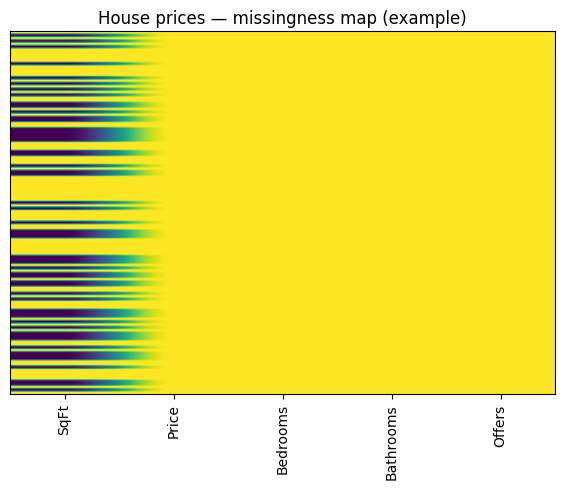

In [14]:
# Exercise starter (House prices example)
dfh0 = df_house.copy()
col = "SqFt"
dfh_mcar = inject_mcar(dfh0, col=col, missing_rate=0.4, rng=np.random.default_rng(10))

print("Original mean:", float(dfh0[col].mean()))
print("Complete-case mean (MCAR):", float(dfh_mcar[col].dropna().mean()))

plot_missingness_map(dfh_mcar[[col, "Price", "Bedrooms", "Bathrooms", "Offers"]], title="House prices — missingness map (example)")
